In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, BSpline
import numpy as np
from scipy import stats
import random
import math
from footprint_filter import filter_by_footprint
from voidiness import voidy_analysis

In [2]:
sdss_dr16 = pd.read_excel('exported_dataFrames/sdss_dr16_w_voidiness.xlsx')
four_lac = pd.read_excel('exported_dataFrames/4lac_w_voidiness.xlsx')

In [29]:
hard_xrays = pd.read_excel('exported_dataFrames/SBAT104_w_voidiness.xlsx')
soft_xrays = pd.read_excel('exported_dataFrames/ROMABZCAT_w_voidiness.xlsx')

In [35]:
catalogs = ["Four_LAC","TEV_Sources", "NON_TEV_Sources", "SDSS_DR16", "ROMABZCAT", "SBAT104"]
stat_nums = ["Statistic", "pvalue"]
statistics = pd.DataFrame(np.nan, columns=catalogs, index  =catalogs)
data = [four_lac.Voidiness,
        four_lac.Voidiness[four_lac.TeVflag == 1],
        four_lac.Voidiness[np.isnan(four_lac.TeVflag)],
        sdss_dr16.Voidiness,
        soft_xrays.Voidiness,
        hard_xrays.Voidiness]

In [36]:
statistics = {}
for i in range(len(data)):
    temp = {}
    for j in range(i, len(data)): 
        temp[catalogs[j]] = stats.ks_2samp(data[i], data[j])
        # print(catalogs[i], catalogs[j], stats.ks_2samp(data[i], data[j]))
    statistics[catalogs[i]] = temp

In [37]:
stats_table = pd.DataFrame(statistics)

In [38]:
stats_table

,Four_LAC,TEV_Sources,NON_TEV_Sources,SDSS_DR16,ROMABZCAT,SBAT104
Four_LAC,"(0.0, 1.0)",NaN,NaN,NaN,NaN,NaN
TEV_Sources,"(0.15670731707317073, 0.6853632429122397)","(0.0, 1.0)",NaN,NaN,NaN,NaN
NON_TEV_Sources,"(0.010175799809946151, 1.0)","(0.16688311688311688, 0.61235328769397)","(0.0, 1.0)",NaN,NaN,NaN
SDSS_DR16,"(0.11666147193662169, 0.00024682521625024915)","(0.20933354901326434, 0.3010003051020268)","(0.12224430373896567, 0.0001863034328030673)","(0.0, 1.0)",NaN,NaN
ROMABZCAT,"(0.07845985201425049, 0.1827442706926773)","(0.19269662921348316, 0.4224222232442778)","(0.07430322486502262, 0.2510548851662401)","(0.06283992308223585, 0.05791296575557536)","(0.0, 1.0)",NaN
SBAT104,"(0.15853658536585366, 0.004626206199868378)","(0.24456521739130435, 0.1946353740374229)","(0.15422077922077923, 0.007253402335819552)","(0.11244203601854846, 0.01755757846133372)","(0.11595017098192477, 0.054738484496669036)","(0.0, 1.0)"


In [14]:
# Taken from custom_functions.py and modified for our purposes, 
# Since I've making new scripts for everything custom_functions is kind of depecrated
# and I didn't want to break it. 

def rand_long_and_lat(n, seeded=False, seed = 567307250717):
    """
    Generates number of longitude and latitude coordinates in degrees for entire pandasDF
    """
    if seeded:
        seed = seed # Using seed while debugging
    else:
        seed = None

    rng = np.random.default_rng(seed) 
    theta = np.arccos(1 - 2 * rng.uniform(0, 1, n)) * (180/math.pi) # COLAT
    b = 90 - theta
    l = rng.uniform(0, 360, n)
    return (l, b)
# Randomize

def gen_filtered_ra_deg(n):
    randRA, randDE = rand_long_and_lat(n)
    temp_cel = pd.DataFrame({'RAdeg': randRA, 'DEdeg': randDE})
    temp_cel = filter_by_footprint(temp_cel, 'exported_dataFrames/footprint_points_void_centers.xlsx')
    return temp_cel

In [15]:
# Monte Carlo of TEV
voids = pd.read_excel('exported_dataFrames/voids.xlsx')
master_TEV_Carlo = four_lac[four_lac.TeVflag == 1].copy()

run_n = 0
mc_voidiness = np.array([])
n_galxy = len(master_TEV_Carlo)


In [49]:

while True:
    coords = gen_filtered_ra_deg(100000)
    coords_idx = coords.index.tolist()
    while len(coords_idx) > n_galxy:
        fresh_coords_idx = coords_idx[:n_galxy]
        coords_idx = coords_idx[n_galxy:]

        master_TEV_Carlo['RAdeg'] = coords.RAdeg[fresh_coords_idx].values
        master_TEV_Carlo['DEdeg'] = coords.DEdeg[fresh_coords_idx].values
        mc_voidiness = np.append(mc_voidiness, voidy_analysis(voids, master_TEV_Carlo).Voidiness.values) # This one takes about 6s per run
        run_n += 1
    # print(run_n)

KeyboardInterrupt: 

Text(0.5, 1.0, 'TeV Sources and Simulated TeV Sources')

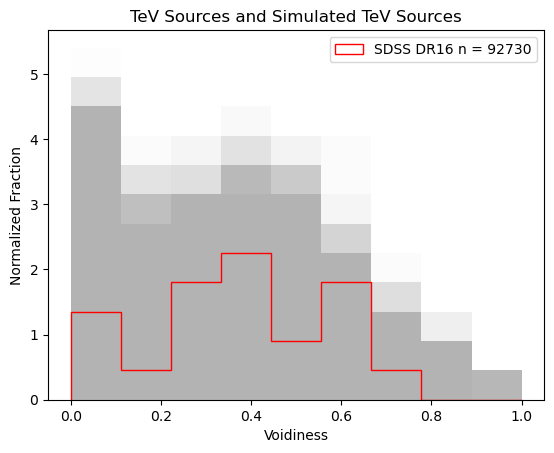

In [237]:
start = 0
end = 1
num = 10

binning = np.linspace(start,end,num)


test = plt.hist([four_lac.Voidiness[four_lac.TeVflag == 1]], 
                     bins = binning, 
                     density=True, 
                     stacked = False,
                     histtype='step', label=f"SDSS DR16 n = {len(sdss_dr16)}",
                     cumulative=False, color = 'red')

# mc_names = ["Voidiness_" + str(i) for i in range(run_n-1)]

# for name in mc_names:
sim_bin_heights = []
for i in range(int(len(mc_voidiness)/20)):
    temp = plt.hist([mc_voidiness[i*20:20*(i+1)]], 
                        bins = binning, 
                        density=True, 
                        stacked = False,
                        # histtype='step', #label=f'Monte Carlo n = {len(mc_voidiness)}',
                        cumulative=False, alpha=0.02, color='0.7')
    sim_bin_heights.append(temp[0])


plt.legend()
plt.ylabel('Normalized Fraction')
plt.xlabel('Voidiness')
plt.title('TeV Sources and Simulated TeV Sources')

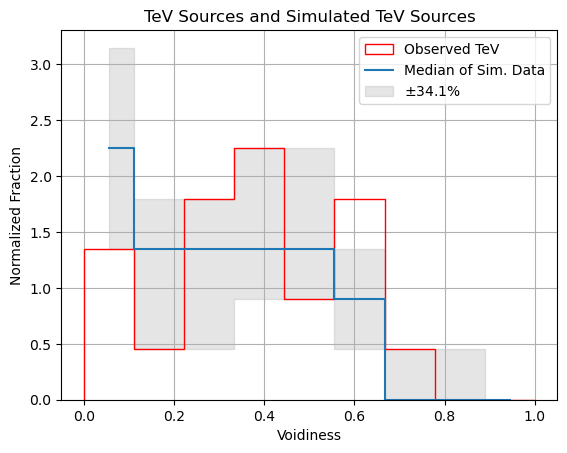

In [238]:
start = 0
end = 1
num = 10

binning = np.linspace(start,end,num)


plt.hist([four_lac.Voidiness[four_lac.TeVflag == 1]], 
                     bins = binning, 
                     density=True, 
                     stacked = False,
                     histtype='step', label=f"Observed TeV",
                     cumulative=False, color = 'red')


org = []
for i in range(9):
    org.append([[heights[i] for heights in sim_bin_heights]])

medians = []
for i in range(9):
    medians.append(np.median(org[i]))

sigmas = []
for i in range(9):
    sigmas.append(np.percentile(org[i], [50-34.1, 50+34.1]))

bin_centers = []
for i in range(len(binning)-1):
    bin_centers.append((binning[i] + binning[i+1])/2)

sigmas = []
for i in range(9):
    sigmas.append(np.percentile(org[i], [50-34.1, 50+34.1]))


low_1sig = [uh[0] for uh in sigmas]
hi_1sig = [uh[1] for uh in sigmas]
# plt.hist([sdss_dr16.Voidiness], 
#     bins=10, 
#     histtype="step", 
#     density=True, 
#     stacked=False,
#     label='SDSS DR16',
#     cumulative=False)
# plt.hist([soft_xrays.Voidiness], 
#     bins=10, 
#     histtype="step", 
#     density=True, 
#     stacked=False,
#     label='SODR',
#     cumulative=False)
# plt.hist([sdss_dr16.Voidiness], 
#     bins=10, 
#     histtype="step", 
#     density=True, 
#     stacked=False,
#     label='NON TEV Sources',
#     cumulative=False)


plt.step(bin_centers, medians, where="mid", label="Median of Sim. Data")
# plt.step(bin_centers, low_1sig, where="mid", label = "-1 $\sigma$")
# plt.step(bin_centers, hi_1sig, where="mid", label = "+1 $\sigma$")
plt.fill_between(bin_centers, hi_1sig, low_1sig, step="mid", alpha = 0.2, color = '0.5', label='$\pm 34.1 \% $')
# plt.plot(medians)
plt.legend()
plt.ylabel('Normalized Fraction')
plt.xlabel('Voidiness')
plt.title('TeV Sources and Simulated TeV Sources')
plt.grid()

plt.savefig('stats_fig/test.png')


In [60]:
mean_voidiness = []
std_voidiness = []
for i in range(20):
    mean_voidiness.append(np.mean(mc_voidiness[i::20]))
    std_voidiness.append(np.std(mc_voidiness[i::20]))

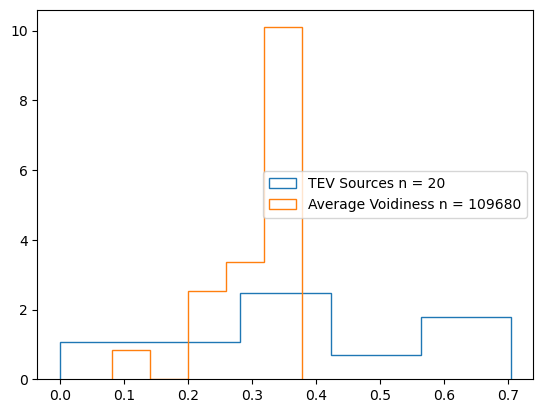

In [72]:
plt.hist([four_lac.Voidiness[four_lac.TeVflag == 1]], 
                    bins = 5, 
                    density=True, 
                    stacked = False,
                    histtype='step', label=f'TEV Sources n = 20',
                    cumulative=False)
plt.hist([mean_voidiness], 
                    bins = 5, 
                    density=True, 
                    stacked = False,
                    histtype='step', label=f'Average Voidiness n = {len(mc_voidiness)}',
                    cumulative=False)
plt.legend()

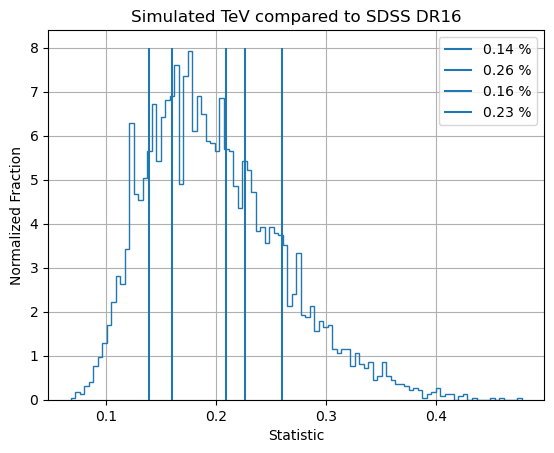

In [226]:
p_vals = []

for i in range(int(len(mc_voidiness)/20)):
    p_vals.append(stats.ks_2samp(sdss_dr16.Voidiness, mc_voidiness[20*i:20*(i+1)])[0])

np.std(p_vals)
plt.hist(p_vals, 
        bins = 100, 
        density=True, 
        stacked = False,
        histtype='step',
        cumulative=False)
plt.ylabel("Normalized Fraction")
plt.xlabel("Statistic")
plt.title("Simulated TeV compared to SDSS DR16")
plt.grid()
plt.vlines(0.209, 0, 8)
percentiles = np.percentile(p_vals, [50-34.1, 50+34.1,50-34.1+13.6, 50+34.1-13.6])
# for perc in percentiles:
#     plt.vlines(perc, 0, 8, label=f'{perc:.2f} %')
plt.legend()
# plt.xlim((0,))
# plt.xscale("log")

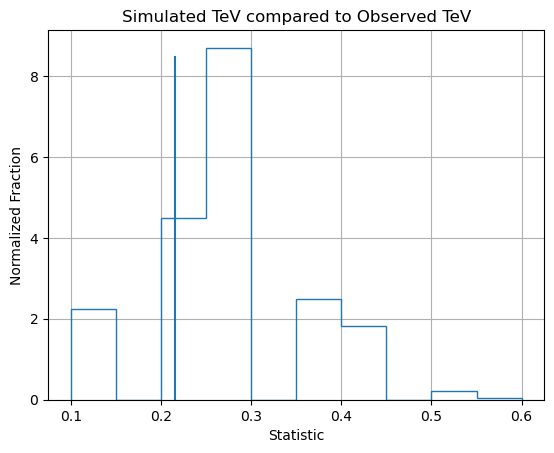

In [222]:
s_vals = []

for i in range(int(len(mc_voidiness)/20)):
    s_vals.append(stats.ks_2samp(four_lac.Voidiness[four_lac.TeVflag==1], mc_voidiness[20*i:20*(i+1)])[0])

np.std(s_vals)
plt.hist(s_vals, 
        bins = 10, 
        density=True, 
        stacked = False,
        histtype='step',
        cumulative=False)
plt.ylabel("Normalized Fraction")
plt.xlabel("Statistic")
plt.title("Simulated TeV compared to Observed TeV")
plt.grid()
plt.vlines(0.21558169219547774, 0, 8.5)
# plt.xlim((0,))
# plt.xscale("log")

In [215]:
from sys import getsizeof

# Only takes up 1 megabyte. I could totally do this multiple times. 
getsizeof(mc_voidiness)/1e6

0.877552

In [221]:
stats.ks_2samp(four_lac.Voidiness[four_lac.TeVflag==1], mc_voidiness)

KstestResult(statistic=0.21558169219547774, pvalue=0.2694652327294371, statistic_location=0.2802346593985992, statistic_sign=-1)